In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import fnmatch
from os.path import basename

## read in and pre-process data. All files with .dat extension in  current directory are processed

0.61597
1 cbc01_C11-F_100.dat 145000
2 cbc02_C11-F_100.dat 145000
3 cbc03_C11-F_100.dat 145000
4 cbc04_C11-F_100.dat 145000
5 cbc05_C11-F_100.dat 145000
6 cbc06_C11-F_100.dat 145000
7 cbc07_C11-F_100.dat 145000
8 cbc08_C11-F_100.dat 145000
9 cbc09_C11-F_100.dat 145000
10 cbc10_C11-F_100.dat 145000
11 cbc11_C11-F_100.dat 145000
12 cbc12_C11-F_100.dat 145000
13 cbc13_C11-F_100.dat 145000
14 cbc14_C11-F_100.dat 145000
15 cbc15_C11-F_100.dat 145000
16 cbc16_C11-F_100.dat 145000
17 cbc17_C11-F_100.dat 145000
18 cbc18_C11-F_100.dat 145000
19 cbc19_C11-F_100.dat 145000
20 cbc20_C11-F_100.dat 145000
21 cbc21_C11-F_100.dat 145000
22 cbc22_C11-F_100.dat 145000
23 cbc23_C11-F_100.dat 145000
24 cbc24_C11-F_100.dat 145000
25 cbc25_C11-F_100.dat 145000
26 cbc26_C11-F_100.dat 145000
27 cbc27_C11-F_100.dat 145000
28 cbc28_C11-F_100.dat 145000
29 cbc29_C11-F_100.dat 145000
30 cbc30_C11-F_100.dat 145000
31 cbc31_C11-F_100.dat 145000
32 cbc32_C11-F_100.dat 145000
33 cbc33_C11-F_100.dat 145000
34 cbc34_C1

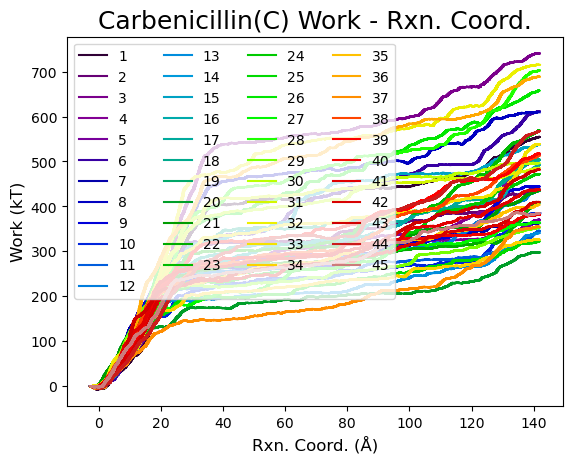

In [3]:
# create color map for plots
cm = plt.get_cmap('nipy_spectral')
colors = [cm(1.*i/46) for i in range(46)]

# output in SMD is reported as time step (unitless), force (pN)

v = 0.005 #the velocity unit is A/ps --> Angstrom/timestep = 0.00001/2fs = 0.005 A/ps = 5 A/ns
TS = 0.2 #smd output saving frequency is 100 timestep which is 2 fs * 100 = 200 fs = 0.2 ps
temperature = 310 # temperature of the simulations
kB = 1.987e-3 # Boltzmann constant in kcal/mol/K
kBT = kB * temperature #temperature * Boltzmann's constant --> 310 * kB = 0.6186 kcal/mol
print (kBT)
conv_factor = 0.0144 #NAMD reports forces in pN; u converts the outputs of W = v*TS*f to kcal/mol
count = 0
N_max = 145000 # no. of data points to read from the files; this should be the shorter than the shortest no of data points amongst all uploaded files.

jW_data = []
jWx_data = []
W_data = []
Wsq_data = []
t_data = []

for file in sorted(os.listdir('.')):
    if fnmatch.fnmatch(file, '*.dat'):
        prefix_name = file
        data = np.genfromtxt(prefix_name)
        timestep = data[0:N_max,0]    # read the position of SMD atom projected on the pulling direction  
        t = timestep - timestep[0]   # rxn coordinate starts from 0 at init. position and is along the pulling dir.
        force = data[0:N_max,1]
        f = np.cumsum(force, axis=0)
        W = v*TS*f*conv_factor / kBT # work values in units of kT
        Wsq = np.square(W)
        count += 1 
        
    #plotting each Work curve
        plt.plot(t,W,color=colors[count],label=count)
        jW = np.exp(-W)
        W_max = np.max(-W)  # maximum argument for Work values; to be used in std error of exponential averaging
        jWx = np.exp(-W-W_max)
        print(count,prefix_name,len(jW))
        
    #appending all data necessary 
        jW_data.append(jW)
        jWx_data.append(jWx)
        W_data.append(W)
        Wsq_data.append(Wsq)
        t_data.append(t)
        

plt.legend(loc='upper left')
plt.xlabel('Time (ns)')
plt.ylabel('Work (kT)')

plt.legend(loc='upper left', ncol=4)

plt.title("Carbenicillin(C) Work - Rxn. Coord.", fontsize=18)
plt.xlabel('Rxn. Coord. (\u212B)', fontsize=12)
plt.ylabel('Work (kT)', fontsize=12)
plt.savefig('cbc_C_W.png', dpi=300, bbox_inches='tight')


### Read in the data and process; this reads in all files in the current directory with the extension .dat

In [4]:
jWmean = np.mean(jW_data, axis = 0) # exponential averages
jWxmean = np.mean(jWx_data, axis = 0) # averages of the deviations from the distribution
jWxsterr = np.std(jWx_data, axis=0)/ np.sqrt(count) / jWxmean #standard error on exponential averaging
jWfinal = -np.log(jWmean)

Wmean = np.mean(W_data, axis = 0) #average work
Wsterr = np.std(W_data, axis=0) / np.sqrt(count)  #standard error


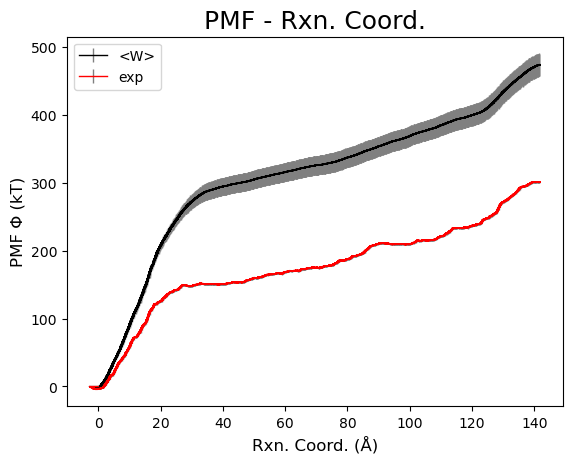

In [5]:
plt.title("PMF - Rxn. Coord.", fontsize=18)
plt.xlabel('Rxn. Coord. (\u212B)', fontsize=12)
plt.ylabel('PMF \u03A6 (kT)', fontsize=12)

#plt.plot(t,Wmean,color='black',label='Mean Work') 
plt.errorbar(t,Wmean, yerr = Wsterr,fmt='-',ecolor = 'gray',color='black',errorevery = 100, linewidth=1,label='<W>')
plt.legend()
plt.savefig('cbc_meanwork.png', dpi=300, bbox_inches='tight')


### Now the same calculations with binning

In [8]:
#=============================================================================================
# PARAMETERS
#=============================================================================================
K = count # number of samples
nbins = 100 # number of bins for 1D PMF
total_rxncoord = 140 # total rxn coordinate to be plotted

#=============================================================================================
# Allocate storage for simulation data
#=============================================================================================
N_k = np.zeros([K], dtype = int) # N_k[k] is the number of snapshots from umbrella simulation k


In [9]:
# Construct bins on rxn coordinate

for k in range(K):
    N_k[k] = N_max

print("Binning data...")
delta = total_rxncoord / float(nbins) 
print(delta)

# compute bin centers
bin_center_i = np.zeros([nbins], np.float64)
for i in range(nbins):
    bin_center_i[i] = delta/2 + delta * i
print(bin_center_i)    
# Bin data
bin_kn = np.zeros([K,N_max], np.int32)
for k in range(K):
    for n in range(N_k[k]):
        # Compute bin assignment.
        bin_kn[k,n] = int(t_data[k][n] / delta)


Binning data...
1.4
[  0.7   2.1   3.5   4.9   6.3   7.7   9.1  10.5  11.9  13.3  14.7  16.1
  17.5  18.9  20.3  21.7  23.1  24.5  25.9  27.3  28.7  30.1  31.5  32.9
  34.3  35.7  37.1  38.5  39.9  41.3  42.7  44.1  45.5  46.9  48.3  49.7
  51.1  52.5  53.9  55.3  56.7  58.1  59.5  60.9  62.3  63.7  65.1  66.5
  67.9  69.3  70.7  72.1  73.5  74.9  76.3  77.7  79.1  80.5  81.9  83.3
  84.7  86.1  87.5  88.9  90.3  91.7  93.1  94.5  95.9  97.3  98.7 100.1
 101.5 102.9 104.3 105.7 107.1 108.5 109.9 111.3 112.7 114.1 115.5 116.9
 118.3 119.7 121.1 122.5 123.9 125.3 126.7 128.1 129.5 130.9 132.3 133.7
 135.1 136.5 137.9 139.3]


In [10]:
# Compute the free energies for these states.
Wmean_i = np.zeros([nbins], np.float64)
Wsterr_i = np.zeros([nbins], np.float64)
Wsq_mean_i = np.zeros([nbins], np.float64)
Wmean_sq_i = np.zeros([nbins], np.float64)
jWmean_i = np.zeros([nbins], np.float64)
jWxmean_i = np.zeros([nbins], np.float64)
jWxsterr_i = np.zeros([nbins], np.float64)

for i in range(nbins):

    # Get linear n-indices of samples that fall in this bin.
    indices = np.where(bin_kn == i)    
    # Compute dimensionless free energy of occupying state i.
    Wmean_i[i] = np.mean(np.array(W_data)[indices])  ### from mean of work
    Wsterr_i[i] = np.std(np.array(W_data)[indices]) / np.sqrt(count)    
    Wsq_mean_i[i] = np.mean(np.array(Wsq_data)[indices]) #calculates average of work^2 for each bin
    jWmean_i[i] = np.mean(np.array(jW_data)[indices])  ### exponential averages
    jWxmean_i[i] = np.mean(np.array(jWx_data)[indices])  ### averages of the deviations from the distribution
    jWxsterr_i[i] = np.std(np.array(jWx_data)[indices]) / np.sqrt(count) / jWxmean_i[i]

#    print(i,Wmean_i[i])

jWfinal_i = -np.log(jWmean_i)
Wmean_sq_i = np.square(Wmean_i) # takes square of average work
diff_i = Wmean_i - (Wsq_mean_i - Wmean_sq_i)*count/(count-1)/2

f = open('AA_data.txt', 'w')
f.write('energies in units of kT \n')
f.write('Rxn. coord (\u212B), <W>, d<W>, exp avg., d(exp avg.) \n')
data = np.column_stack((bin_center_i,Wmean_i,Wsterr_i, jWfinal_i, jWxsterr_i))
np.savetxt(f, data,fmt='%7.2f')
f.close()

#print(i,Wmean_i,jWfinal_i)


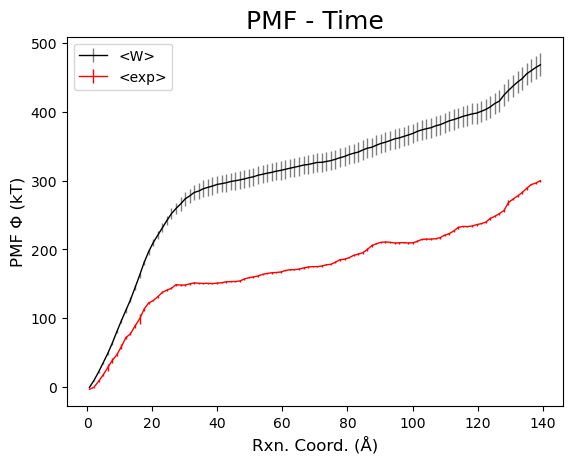

In [11]:
plt.title("PMF - Time", fontsize=18)
plt.xlabel('Rxn. Coord. (\u212B)', fontsize=12)
plt.ylabel('PMF \u03A6 (kT)', fontsize=12)

#plt.plot(bin_center_i,Wmean_i,color='black',label='Mean Work') 
plt.errorbar(bin_center_i,Wmean_i, yerr = Wsterr_i,fmt='-',ecolor = 'gray',color='black',errorevery = 1, linewidth=1,label='<W>')
plt.legend()
#plt.savefig('cbc_meanwork.png', dpi=300, bbox_inches='tight')

#plt.plot(bin_center_i,diff_i,'ro',label='Mean Work') 
#plt.plot(t,Wmean,color='red',label='Mean Work') 
plt.errorbar(bin_center_i,jWfinal_i, yerr = jWxsterr_i,fmt='-',ecolor = 'red',color='red',errorevery = 1, linewidth=1,label='<exp>')
plt.legend()

plt.savefig('cbc_binned.png', dpi=300, bbox_inches='tight')